In [2]:
#import seaborn as sns
import pandas as pd
import cooler


In [1]:
scool_path = '/store/zlwang/Workspace/Myproject/hicool/data/DipC2019/DipC2019_100000.scool'


In [3]:
raw_adjs.shape

torch.Size([236, 1955, 1955])

In [4]:
oe_adjs = load_scool_adj(scool_path,transform='OE')

In [5]:
cool_path =  '/store/zlwang/Workspace/Project/scHiC/result/DipC2019/DipC2019_100000_merged.cool'
chrom = 'chr1'
clr = cooler.Cooler(cool_path)
raw_adj = clr.matrix(balance=False).fetch(chrom,chrom)

In [6]:
oe_adjs.shape

torch.Size([236, 1955, 1955])

In [7]:
from hicool.gae.model import GCNModelVAE
from hicool.gae.optimizer import loss_function
import numpy as np
import scipy.sparse as sp
import torch
from torch import optim

In [8]:
dataset_str = 'citeseer'
path = '/store/zlwang/Workspace/Myproject/hicool/scripts/hicool/gae/data/'
hidden1 = 64
hidden2 = 16
dropout = 0.7
lr = 0.01
epochs = 100

In [9]:
from hicool.gae.utils import load_data, mask_test_edges, preprocess_graph, get_roc_score

adj, features = load_data(dataset_str,path)
n_nodes, feat_dim = features.shape

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train

# Some preprocessing
adj_norm = preprocess_graph(adj)
adj_label = adj_train + sp.eye(adj_train.shape[0])
# adj_label = sparse_to_tuple(adj_label)
adj_label = torch.FloatTensor(adj_label.toarray())

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

/store/zlwang/Workspace/Myproject/hicool/scripts/hicool/gae/utils.py:43: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))


In [10]:
adj.shape

(3327, 3327)

In [11]:
features.shape

torch.Size([3327, 3703])

In [12]:
model = GCNModelVAE(feat_dim, hidden1, hidden2, dropout)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [13]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    recovered, mu, logvar = model(features, adj_norm)
    loss = loss_function(preds=recovered, labels=adj_label,
                            mu=mu, logvar=logvar, n_nodes=n_nodes,
                            norm=norm, pos_weight=pos_weight)
    loss.backward()
    cur_loss = loss.item()
    optimizer.step()

    hidden_emb = mu.data.numpy()

In [14]:
model.gc1

GraphConvolution (3703 -> 64)

In [15]:
hidden_emb.shape

(3327, 16)

In [16]:
mu.shape

torch.Size([3327, 16])

In [17]:
recovered.shape

torch.Size([3327, 3327])

In [18]:
logvar.shape

torch.Size([3327, 16])

<AxesSubplot:>

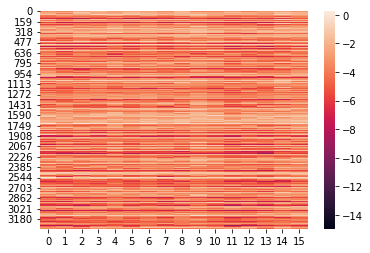

In [20]:
import seaborn as sns  
sns.heatmap(logvar.detach().numpy())